## **1.2 $\texttt{P-VAE Synth}$ testing**

Experiments regarding the $\texttt{P-VAE Synth}$.

In [35]:
#Git clone the ddsp_textures repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/ddsp_textures.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'ddsp_textures'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/ddsp_textures.


In [36]:
#Add the ddsp's parent directory to the Python path so that we can import the necessary modules
import sys

ddsp_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if ddsp_dir not in sys.path:
    sys.path.append(ddsp_dir)

In [37]:
# import modules
import ddsp_textures.signal_processors.synthesizers as sp
import ddsp_textures.auxiliar.time_stamps           as ts
import ddsp_textures.architectures.VAE               as VAE

# Extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import itertools

### Experiment 1: Time stamps generator

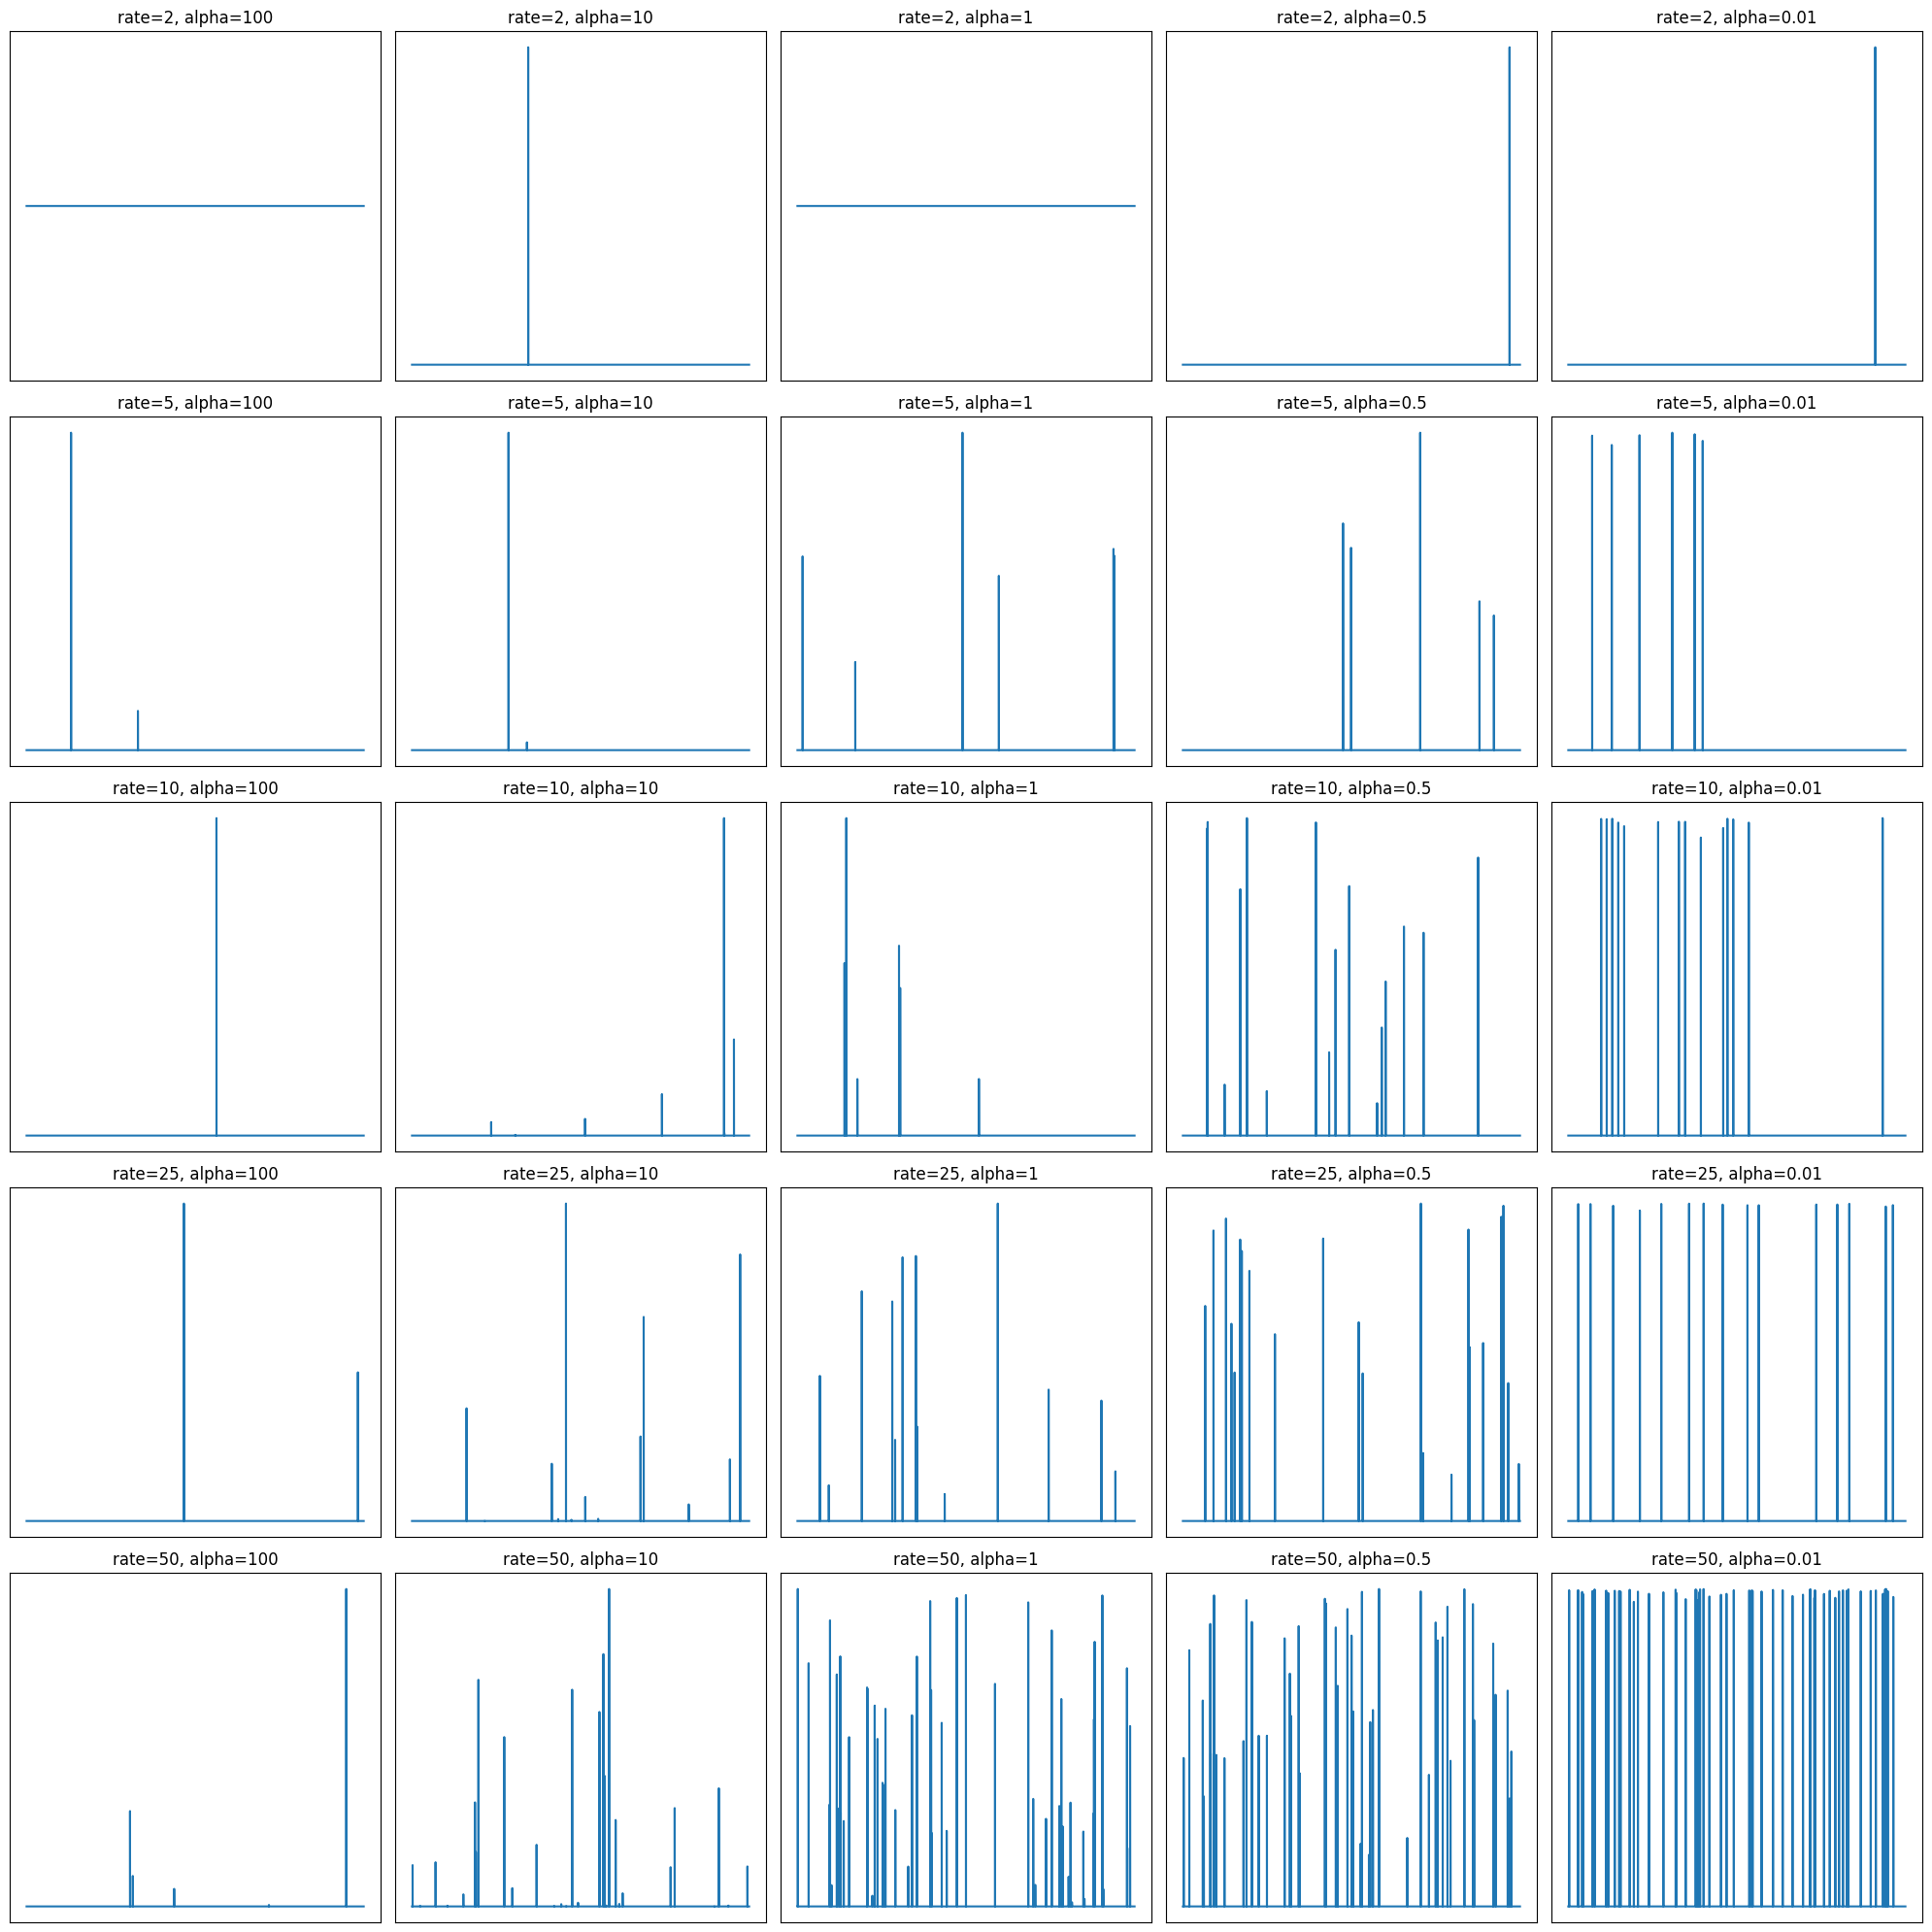

In [38]:
# Provided lists of parameters
rates = [2, 5, 10, 25, 50]
alphas = [100, 10, 1, 0.5, 0.01]

# Provided constants
sr = torch.tensor(44100.)  # standard sr
size = 44100  # 1 second

# Grid size
n_rows = len(rates)
n_cols = len(alphas)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# Iterate over all combinations of rates and alphas
for i, (rate, alpha) in enumerate(itertools.product(rates, alphas)):
    row = i // n_cols
    col = i % n_cols

    # Generate the time_stamp tensor
    time_stamp = ts.time_stamps_generator(size, sr, rate, alpha)

    # Plot on the corresponding subplot
    axes[row, col].plot(time_stamp.numpy())
    axes[row, col].set_title(f'rate={rate}, alpha={alpha}')
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Adjust the layout
plt.tight_layout()
plt.show()

### Extra: Density of probability for atoms amplitude.

/tmp/ipykernel_3451381/2009939348.py:4: RuntimeWarning: divide by zero encountered in power
  return (1/alpha) * np.power(x,((1-alpha)/alpha))


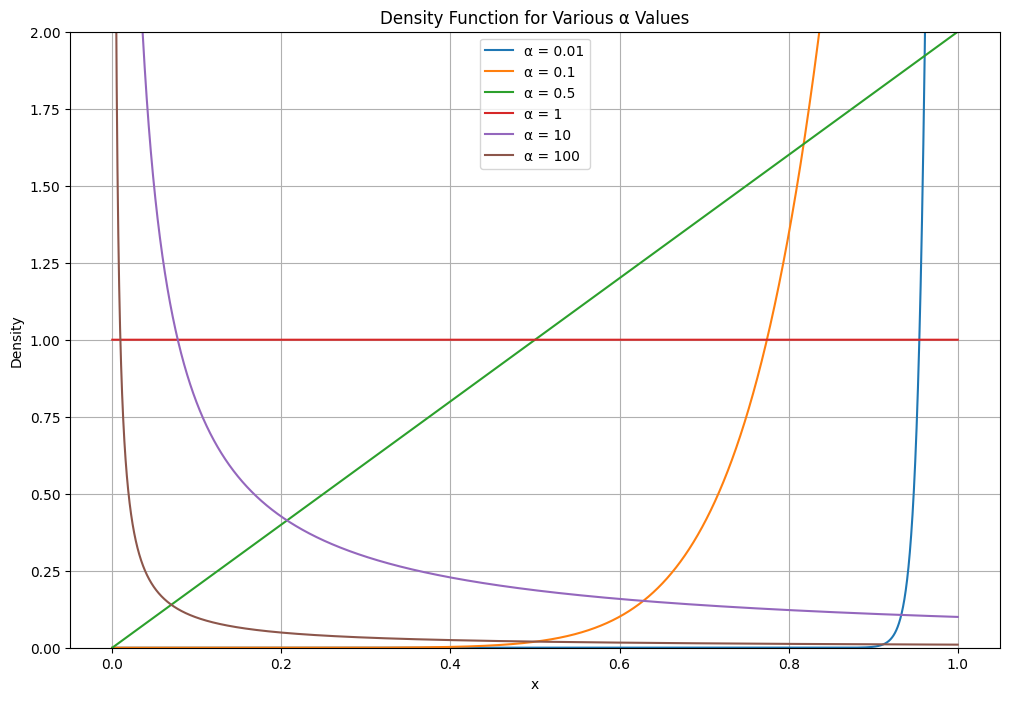

In [39]:
# Distribution of amplitudes 

def density(x, alpha):
    return (1/alpha) * np.power(x,((1-alpha)/alpha))    

# Values for alpha
alpha_values = [0.01, 0.1, 0.5, 1, 10, 100]

# Plotting the density functions
x = np.linspace(0, 1, 10000)
plt.figure(figsize=(12, 8))

for alpha in alpha_values:
    plt.plot(x, density(x, alpha), label=f'α = {alpha}')

plt.xlabel('x')
plt.ylabel('Density')
plt.ylim(0, 2)
plt.title('Density Function for Various α Values')
plt.legend()
plt.grid(True)
# plt.savefig('density_functions.png')
plt.show()

### Experiment 2: Atom generation through a VAE + the SubEnv Synth

In order to train a VAE to be used as an atom generator we used the repo VAE_SubEnv. The following is an example of how to run the trainer, however the training was actually run in the HPC cluster of the Universitat Pompeu Fabra.

In [40]:
#Git clone the VAE_SubEnv repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/VAE_SubEnv.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'VAE_SubEnv'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/VAE_SubEnv.


In [41]:
# import modules
from VAE_SubEnv.modules.dataset import *
from VAE_SubEnv.modules.seeds import *
from VAE_SubEnv.modules.architecture import *
from VAE_SubEnv.modules.trainer import *

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

audio_path = '../data/sounds/water_augmented.wav'

frame_size, N_filter_bank, param_per_env = 17640, 24, 512
hidden_size, deepness = 512, 3
latent_dim = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sr = 44100
seed = seed_maker(frame_size, sr, N_filter_bank)
seed = seed.to(device)

settings = {
    'frame_size': frame_size,
    'hidden_size': hidden_size,
    'deepness': deepness,
    'latent_dim': latent_dim,
    'N_filter_bank': N_filter_bank,
    'param_per_env': param_per_env,
    }

#Dataset loading
dataset = VAE_Dataset(audio_path, frame_size, sr, N_filter_bank)
dataset_list = dataset.compute_dataset()
print("dataset size: ", len(dataset_list))
dataloader = DataLoader(dataset_list, batch_size=16, shuffle=True)

#Model loading
modelo = VAE_SubEnv(hidden_size, deepness, latent_dim, N_filter_bank, param_per_env, seed, device)

#Optimizer
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)

#Training
model_path = '../data/VAE_SubEnv/watermodel/'
# train_statistics_loss(modelo, optimizer, 50, device, dataloader, model_path, N_filter_bank, frame_size, sr, settings)

dataset size:  160


### Experiment 3: Latent Space eploration

Once the model is already trained, you can load it using the load_model function. Let's load the emodel and plot its latent space.

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from VAE_SubEnv.modules.dataset import *
from VAE_SubEnv.modules.seeds import *
from VAE_SubEnv.modules.architecture import *
from VAE_SubEnv.modules.trainer import *

# Display latent space
import torch
import numpy as np
from IPython.display import Audio, display, HTML

def display_latent_space(model, device, sr=44100):
    # Define the grid in the latent space
    grid_size = 5  # Adjust this for more/less granularity
    A = 2
    latents = np.linspace(-1 * A, A, grid_size)
    latent_grid = np.array([[x, y] for x in latents for y in latents])

    # Initialize an empty list to store the generated sounds
    generated_sounds = []

    # Generate sounds for each point in the latent space grid
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for latent_vector in latent_grid:
            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device)
            # latent_tensor = latent_tensor.unsqueeze(0)  # Add batch dimension

            # Generate sound using the VAE's generate function
            generated_sound = model.generate(latent_tensor)

            # Store the generated sound in the list
            generated_sounds.append(generated_sound.cpu().numpy().flatten())  # Flatten to 1D array and move to CPU

    # Reshape the generated sounds into a matrix form
    generated_sounds_matrix = np.array(generated_sounds).reshape(grid_size, grid_size, -1)

    # Display the sounds in a grid layout
    grid_html = "<table>"
    for i in range(grid_size):
        grid_html += "<tr>"
        for j in range(grid_size):
            grid_html += "<td>"
            sound_html = f"Latent: ({latent_grid[i*grid_size+j][0]:.2f}, {latent_grid[i*grid_size+j][1]:.2f})"
            sound_html += "<br>"
            sound_html += Audio(generated_sounds_matrix[i, j, :], rate=sr)._repr_html_()
            grid_html += sound_html
            grid_html += "</td>"
        grid_html += "</tr>"
    grid_html += "</table>"

    display(HTML(grid_html))

In [43]:
# Load the model parameters
model_path          = '../data/models/VAE_SubEnv/water_statistics/best_model.pth'
model_settings_path = '../data/models/VAE_SubEnv/water_statistics/best_model_settings.json'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = load_model(model_path, model_settings_path, device)

#Display latent space
display_latent_space(model, device)

Model loaded from ../data/models/VAE_SubEnv/water_statistics/best_model.pth


### Experiment 4: Exploratory Synthesis

In [47]:
import torch.nn.functional as F

def convolution_step(time_stamps, atoms, K):
    #time stamps size
    N = time_stamps.size()[0]
    #time stamps patch size
    n = N // K
    #atom size
    M = atoms.size()[0] // K
    #set result
    result = torch.zeros(N+M-1)
    for i in range(K):
        atom_local       = atoms[i*M:(i+1)*M].view(1, 1, -1)
        print("atom local size: ", atom_local.size())
        time_stamp_local = time_stamps[i*n:(i+1)*n].view(1, 1, -1)
        print("time stamp local size: ", time_stamp_local.size())
        # Perform the full convolution
        padding = max(M, n)-1
        synthesis_local = F.conv1d(time_stamp_local, atom_local, padding=padding)
        # synthesis_local  = torch.convolution(time_stamp_local, atom_local) #size = n+M-1
        print("synthesis local size: ", synthesis_local.size())
        #squeeze
        synthesis_local = synthesis_local.squeeze()
        #overlap and add using hop size = n
        result[i*n:(i+1)*n+M-1] += synthesis_local
    return result

def convolution_step_batches(time_stamps, atoms, K):
    #compute batch size
    batch_size = time_stamps.size()[0]
    #time stamps size
    N = time_stamps.size()[1]
    #time stamps patch size
    n = N // K
    #atom size
    M = atoms.size()[1] // K
    #set result
    result = torch.zeros(batch_size, N+M-1)
    for i in range(batch_size):
        result[i] = convolution_step(time_stamps[i], atoms[i], K)
    return result

# REQUIREMENTS
# VAE = object that has two methods
# VAE.generate generates a tensor of size atoms_size from a tensor of size latent_dim
# VAE.generate_batches generates a tensor of size batch_size x atoms_size from a tensor of size batch_size x latent_dim
def P_VAE(time_stamps_size, lambda_rate, alpha, sr, VAE, latent_dim, atoms_size, encoded_atoms, atoms_new_size_factor = 1):
    #time stamps generation
    time_stamps = ts.time_stamps_generator(time_stamps_size, sr, lambda_rate, alpha)
    #number of atoms = size of encoded atoms/latent dim
    K = encoded_atoms.size()[0] // latent_dim
    # print("Number of atoms: ", K)
    #create tensor 1d with all the atom
    atoms_new_size_factor = min(1, atoms_new_size_factor)
    new_atoms_size = int(atoms_size * atoms_new_size_factor)
    atoms = torch.zeros(K*new_atoms_size)
    for i in range(K):
        atom_local = VAE.generate(encoded_atoms[i*latent_dim:(i+1)*latent_dim])
        atom_local = atom_local[:new_atoms_size]
        # print("atom local size: ", atom_local.size())
        atoms[i*new_atoms_size:(i+1)*new_atoms_size] = atom_local
    #convolution step
    # print("convolution_step")
    result = convolution_step(time_stamps, atoms, K)
    return result

def P_VAE_batches(time_stamps_size, lambda_rate, alpha, sr, VAE, latent_dim, atoms_size, encoded_atoms, atoms_new_size_factor = 1):
    # lambda is a number but comes ina btach. Compute the size of the batch
    batch_size = lambda_rate.size()[0]
    print(batch_size)
    
    print("let's compute the time stamps")
    #make a batch of time stamps using the batch of lambdas and alphas
    time_stamps_batch = torch.zeros(batch_size, time_stamps_size)
    for i in range(batch_size):
        time_stamps_batch[i] = ts.time_stamps_generator(time_stamps_size, sr, lambda_rate[i], alpha[i])
        print("time stamps number ", i, " computed")
    
    # number of atoms = size of encoded atoms/latent dim but atoms come in batches
    K = encoded_atoms.size()[1] // latent_dim
    print("Number of atoms: ", K)
    
    #create tensor 1d with all the atom
    atoms_new_size_factor = min(1, atoms_new_size_factor)
    print("old atoms size: ", atoms_size)
    new_atoms_size = int(atoms_size * atoms_new_size_factor)
    print("new atoms size: ", new_atoms_size)
    atoms_batch = torch.zeros(batch_size, K*new_atoms_size)
    
    for i in range(K):
        atom_local = VAE.generate_batches(encoded_atoms[:,i*latent_dim:(i+1)*latent_dim])
        atom_local = atom_local[:, :new_atoms_size]
        print("atom local size: ", atom_local.size())
        # print("atom local size: ", atom_local.size())
        atoms_batch[:, i*new_atoms_size:(i+1)*new_atoms_size] = atom_local
    #convolution step
    print("\nCONVOLUTION STEP\n")
    result = convolution_step_batches(time_stamps_batch, atoms_batch, K)
    return result

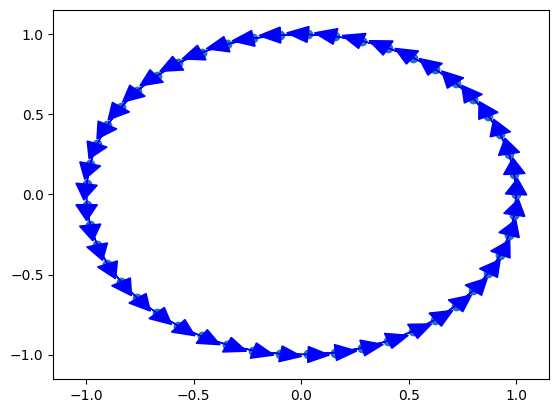

atom local size:  torch.Size([1, 1, 8820])
time stamp local size:  torch.Size([1, 1, 8820])
synthesis local size:  torch.Size([1, 1, 17639])
atom local size:  torch.Size([1, 1, 8820])
time stamp local size:  torch.Size([1, 1, 8820])
synthesis local size:  torch.Size([1, 1, 17639])
atom local size:  torch.Size([1, 1, 8820])
time stamp local size:  torch.Size([1, 1, 8820])
synthesis local size:  torch.Size([1, 1, 17639])
atom local size:  torch.Size([1, 1, 8820])
time stamp local size:  torch.Size([1, 1, 8820])
synthesis local size:  torch.Size([1, 1, 17639])
atom local size:  torch.Size([1, 1, 8820])
time stamp local size:  torch.Size([1, 1, 8820])
synthesis local size:  torch.Size([1, 1, 17639])
atom local size:  torch.Size([1, 1, 8820])
time stamp local size:  torch.Size([1, 1, 8820])
synthesis local size:  torch.Size([1, 1, 17639])
atom local size:  torch.Size([1, 1, 8820])
time stamp local size:  torch.Size([1, 1, 8820])
synthesis local size:  torch.Size([1, 1, 17639])
atom local si

In [48]:
K = 50             #number of atoms
latent_dim = 2     #from VAE model
# atom generation following a circle in the latent space
encoded_atoms = torch.zeros(2*K)
theta         = torch.linspace(0, 2*np.pi, K)
for i in range(K):
    encoded_atoms[i*2]   = torch.cos(theta[i])
    encoded_atoms[i*2+1] = torch.sin(theta[i])
#plot all the encoded atoms
plt.scatter(encoded_atoms[0:2*K:2].numpy(), encoded_atoms[1:2*K:2].numpy())
#plot short blue arrows between the encoded atoms
for i in range(K-1):
    plt.arrow(encoded_atoms[i*2].numpy(), encoded_atoms[i*2+1].numpy(), encoded_atoms[(i+1)*2].numpy()-encoded_atoms[i*2].numpy(), encoded_atoms[(i+1)*2+1].numpy()-encoded_atoms[i*2+1].numpy(), head_width=0.1, head_length=0.1, fc='blue', ec='blue')
plt.show()
atoms_size = 17640 #from VAE model
model = model      #VAE model loaded
time_roughly = 10  #seconds
result = P_VAE(time_stamps_size=time_roughly*sr, lambda_rate=50, alpha=0.1, sr=sr, VAE = model, latent_dim=latent_dim ,atoms_size=atoms_size, encoded_atoms=encoded_atoms, atoms_new_size_factor=0.5).detach().numpy()
#Display Audio
display(Audio(result, rate=sr))

Encoded atoms size:  torch.Size([16, 100])


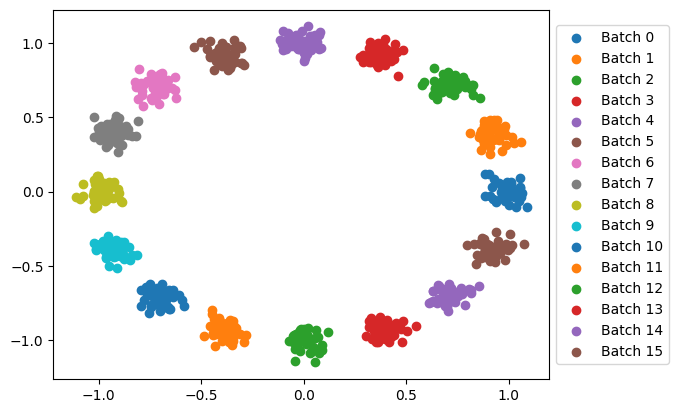

16
let's compute the time stamps
time stamps number  0  computed
time stamps number  1  computed
time stamps number  2  computed
time stamps number  3  computed
time stamps number  4  computed
time stamps number  5  computed
time stamps number  6  computed
time stamps number  7  computed
time stamps number  8  computed
time stamps number  9  computed
time stamps number  10  computed
time stamps number  11  computed
time stamps number  12  computed
time stamps number  13  computed
time stamps number  14  computed
time stamps number  15  computed
Number of atoms:  50
old atoms size:  17640
new atoms size:  2205
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local size:  torch.Size([16, 2205])
atom local siz

In [70]:
batch_size = 16

K = 50
latent_dim = 2     #from VAE model
#make batch random of encoded atoms
encoded_atoms = torch.zeros(batch_size, 2*K)
theta = torch.linspace(0, 2*np.pi - (2*np.pi)/batch_size, batch_size)
for i in range(batch_size):
    for j in range(K):
        encoded_atoms[i, j*2]   = torch.cos(theta[i]) + torch.randn(1)*0.05
        encoded_atoms[i, j*2+1] = torch.sin(theta[i]) + torch.randn(1)*0.05
# print the batch size
print("Encoded atoms size: ", encoded_atoms.size())
#plot all the encoded atoms
for j in range(batch_size):
    plt.scatter(encoded_atoms[j, 0:2*K:2].numpy(), encoded_atoms[j, 1:2*K:2].numpy(),label=f'Batch {j}')
#plot legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# batch of rates
lambda_rate_batch = torch.zeros(batch_size, 1)
for j in range(batch_size):
    lambda_rate_batch[j,0] = 10*(j+1)

alpha_batch = torch.ones(batch_size, 1)*0.5

atoms_size = 17640 #from VAE model
model = model      #VAE model loaded
time_roughly = 2  #seconds
result = P_VAE_batches(time_stamps_size=time_roughly*sr, lambda_rate=lambda_rate_batch, alpha=alpha_batch, sr=sr, VAE = model, latent_dim=latent_dim ,atoms_size=atoms_size, encoded_atoms=encoded_atoms, atoms_new_size_factor=0.125)
# #Display Audio
# display(Audio(result, rate=sr))

torch.Size([16, 90404])


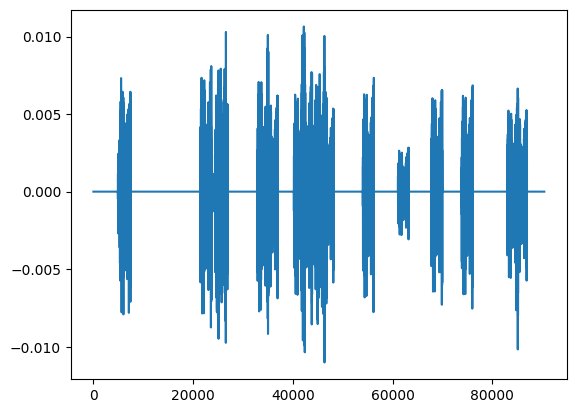

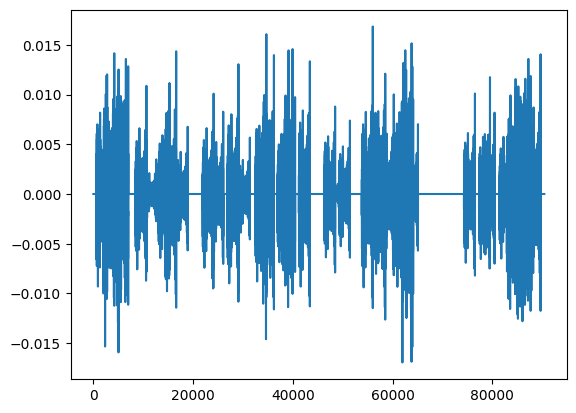

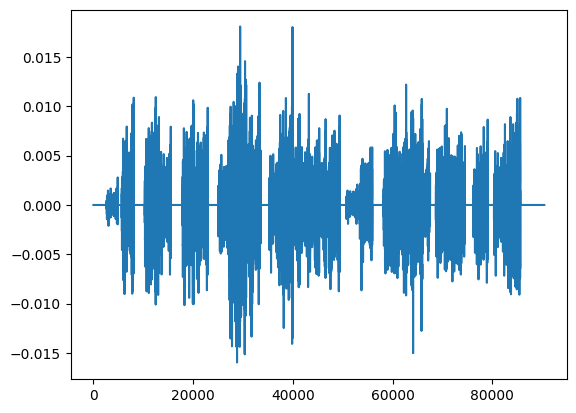

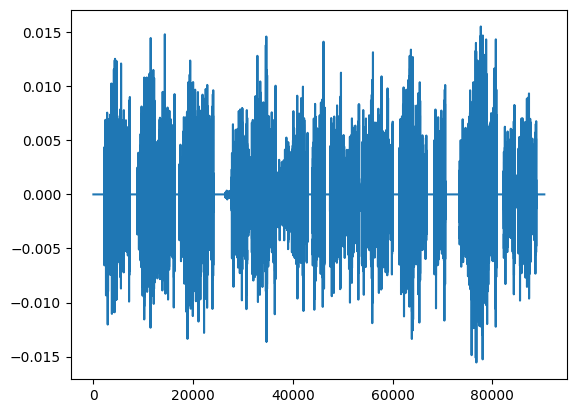

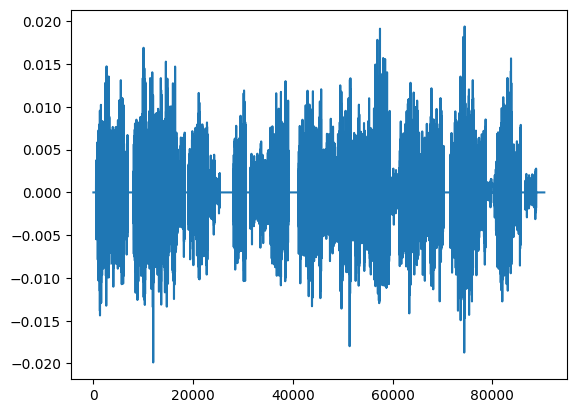

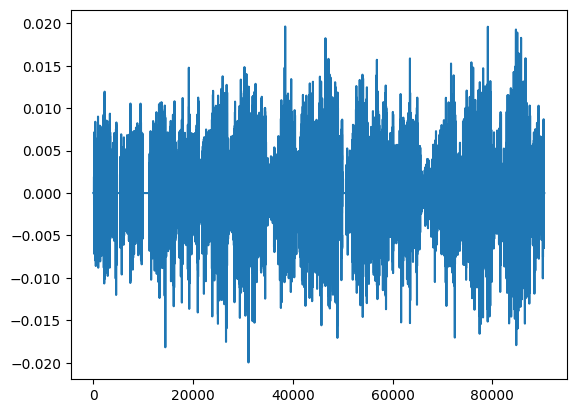

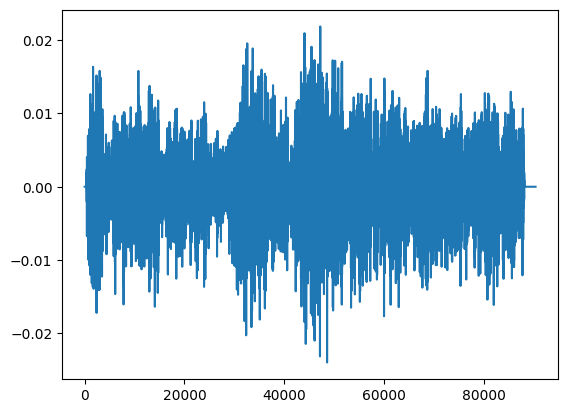

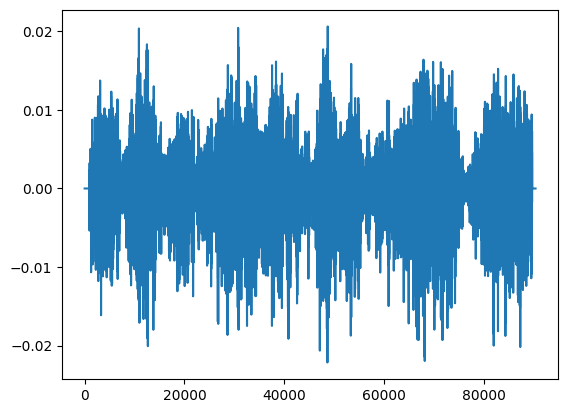

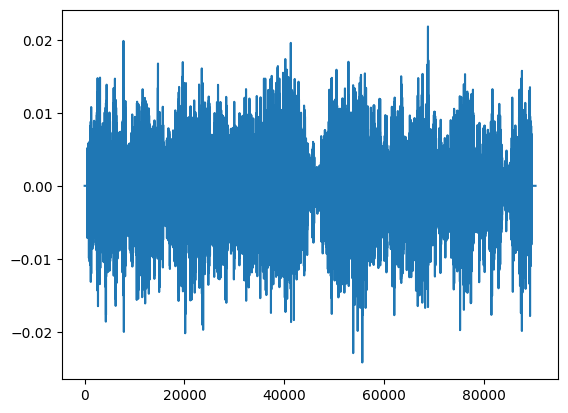

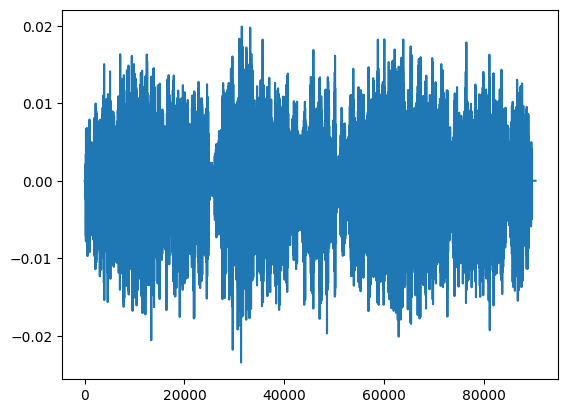

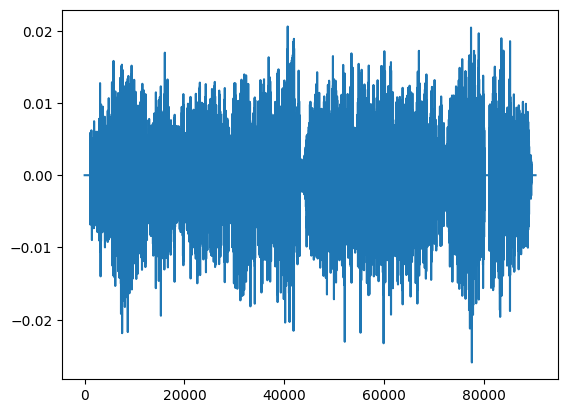

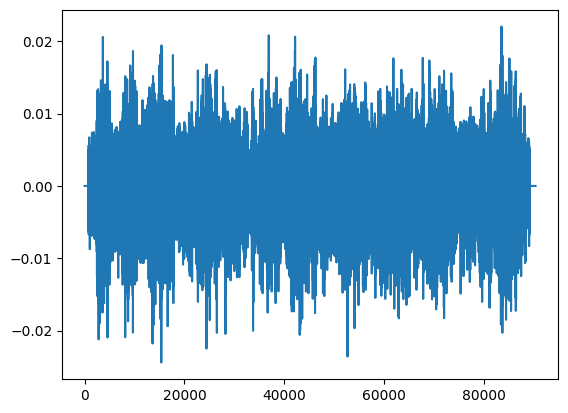

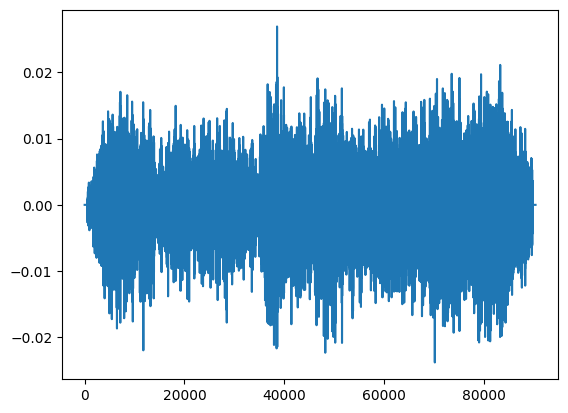

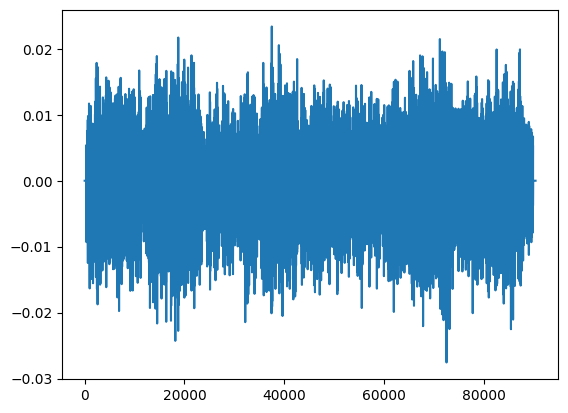

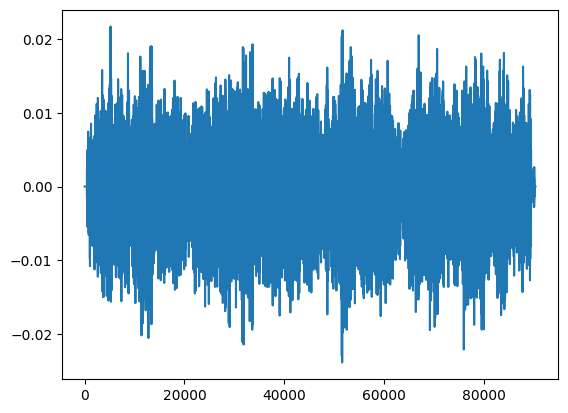

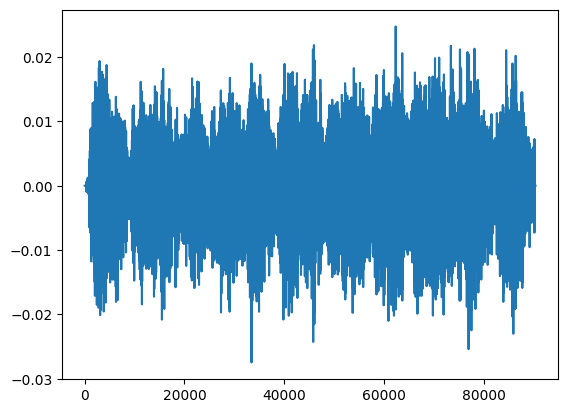

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

print(result.size())
for j in range(batch_size):
    audio = result[j, :]
    audio_numpy = audio.detach().numpy()
    
    # Check and handle NaN or Inf values
    if np.isnan(audio_numpy).any() or np.isinf(audio_numpy).any():
        print(f"Warning: Audio contains NaN or Inf values in batch {j}. Replacing with zeros.")
        audio_numpy = np.nan_to_num(audio_numpy)
    
    # Normalize audio to prevent out-of-range values
    audio_numpy = np.clip(audio_numpy, -1, 1)
    
    # Plot audio
    plt.plot(audio_numpy)
    plt.show()
    
    # Display audio
    display(Audio(audio_numpy, rate=sr))